## Initial Setup

In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#these are the key libraries for solving the problem
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

#set plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
figsize = (6.4,4)

#make folder to save plots to
plots_folder = Path('plots')
plots_folder.mkdir(exist_ok=True)

#define conversion constants for ease of use later
INCHES_TO_METERS = 25.4/1000
FEET_TO_METERS = 12*INCHES_TO_METERS
GALLONS_TO_M3 = 0.0037854118 #convert gallons to m^3

## Create Pipe Model

Create dataclass to store fluid properties

In [2]:
@dataclass
class Fluid():
    #fluid defaults to water properties
    rho: float = 997 #kg/m^3
    mu: float = 0.0007972 #N-s/m^2 = kg/m-s
    g: float = 9.81 #m/s^2

Create pipe class that stores pipe dimensions and computes head loss given a set of fluid properties

In [3]:
class Pipe():
    
    def __init__(self, L, D, epsilon, fluid: Fluid):
        
        #pipe dimensions are all assumed to be in meters
        self.L = L
        self.D = D
        self.epsilon= epsilon
        
        #fluid properties
        self.fluid = fluid
        
    @property
    def A(self):
        """computes cross-sectional area of pipe in m^2"""
        
        return np.pi*(self.D/2)**2 #area in m^2
    
    def Q_to_v(self, gpm):
        """Converts gpm to fluid speed in pipe in m/s"""
        
        Q = gpm*GALLONS_TO_M3/60 #flow rate in m^3/s
        return  Q/self.A #flow velocity in m/s
    
    def friction_factor(self, gpm):
        """computes Darcy friction factor, given flow rate in gpm
        
        This method uses Haaland's equation, wich is an explicit approximation
        of the well-known, but implicit Colebrook equation
        """
        #first get flow velocity from flow rate and pipe dimensions
        v = self.Q_to_v(gpm)
        #compute Reynold's number
        Re = self.fluid.rho*v*self.D/self.fluid.mu
        #compute relative roughness
        e_over_d = self.epsilon/self.D
        #use Haaland's equation
        f = (-1.8*np.log10((e_over_d/3.7)**1.11 + 6.9/Re))**-2
        return f
    
    def head_loss(self, gpm):
        """computes head loss in meters, given flow rate in gpm"""
        
        #get flow velocity
        v = self.Q_to_v(gpm)
        #get Darcy friction factor
        f = self.friction_factor(gpm)
        #compute head loss in meters
        hl = 0.5*f*(self.L/self.D)*v**2/self.fluid.g
        return hl
    
    def head_loss_feet(self, gpm):
        """computes head loss in feet, given flow rate in gpm"""
        
        hl_meters = self.head_loss(gpm)
        return hl_meters/FEET_TO_METERS

## Visualize Pipe Model

Create pipe segment with water as fluid and look at head loss as a function of flow rate

In [4]:
#create fluid object for water
water = Fluid()

#create pipe segment with water flowing in it
pipe = Pipe(L=100*FEET_TO_METERS, 
            D=1.25*INCHES_TO_METERS, 
            epsilon=0.00006*INCHES_TO_METERS,
            fluid=water)

Plot loss curve for pipe segment

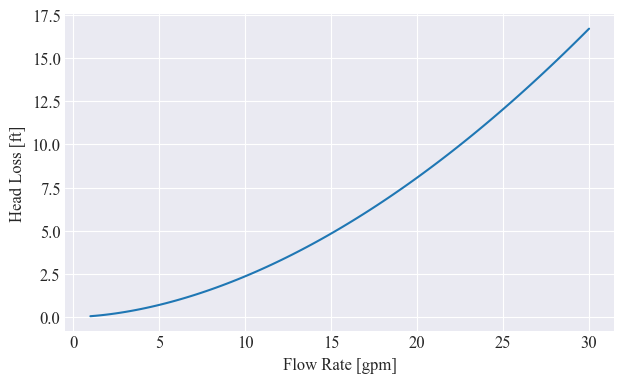

In [5]:
gpm_arr = np.linspace(1,30,100)
hl = [pipe.head_loss_feet(gpm) for gpm in gpm_arr]

fig, ax = plt.subplots(figsize=figsize)
ax.plot(gpm_arr, hl)
ax.set_xlabel('Flow Rate [gpm]')
ax.set_ylabel('Head Loss [ft]')
fig.tight_layout()
fig.savefig(plots_folder/'pipe_loss_curve.png')

## Create Pump Model

Load pump head data into pandas DataFrame

In [6]:
class Pump():
    
    def __init__(self, file):    
        #store file name
        self.file = file 
        #read data into pandas dataframe and assign column names
        self.data = pd.read_csv(file, names=['gpm', 'head [ft]']).set_index('gpm')
        #create continuous interpolation function
        self._interp = interp1d(self.data.index.to_numpy(), self.data['head [ft]'].to_numpy())
        
    @property
    def bounds(self):
        """returns min and max flow rates in pump curve data"""
        return [self.data.index.min(), self.data.index.max()]
        
    def head_gain_feet(self, gpm):
        """return head (in feet) produced by the pump at a given flow rate"""
        return self._interp(gpm)

In [7]:
pump = Pump('pump_data.csv')
pump.data.head()

,head [ft]
gpm,
0.094814,21.862772
0.299946,21.856508
0.505079,21.779414
0.710211,21.706175
0.915344,21.634863


Plot pump curve with head loss data

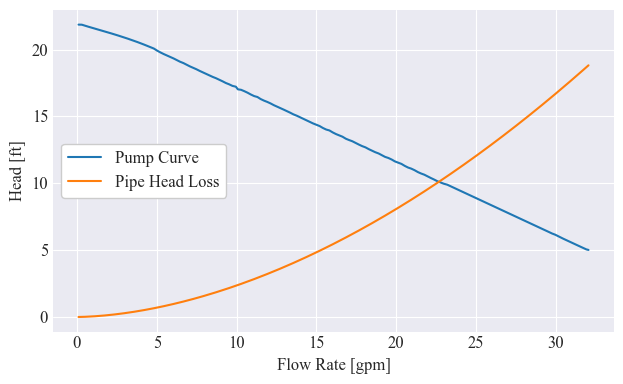

In [8]:
head_loss = [pipe.head_loss_feet(gpm) for gpm in pump.data.index]

fig, ax = plt.subplots(figsize=figsize)
ax.plot(pump.data, label='Pump Curve')
ax.plot(pump.data.index, head_loss, label='Pipe Head Loss')
ax.set_xlabel("Flow Rate [gpm]")
ax.set_ylabel("Head [ft]")
ax.legend(frameon=True, facecolor='w', framealpha=1, loc=6)
fig.tight_layout()
fig.savefig(plots_folder/'pump_curve_with_losses.png')

## Solve Operating Point

define a residual function that computes the difference between the pump head and pipe head loss

In [9]:
class System():
    
    def __init__(self, pipe: Pipe, pump: Pump):
        self.pipe = pipe
        self.pump = pump
        
    def residual(self, gpm):
        """
        Computes the difference between the head produced by the pump
        and the head loss in the pipe. At steady state, the pump head and 
        head loss will be equal and thus the residual function will go to zero
        """
        return self.pump.head_gain_feet(gpm) - self.pipe.head_loss_feet(gpm)
    
    def get_operating_point(self):
        """solve for the flow rate where the residual function equals zero. 
        i.e. the pump head equals the pipe head loss"""
        return root_scalar(sys.residual, bracket=pump.bounds)

solve the root of the residual function (where the residual function equals zero, which corresponds to the pump curve intersecting the head loss curve)

In [10]:
sys = System(pipe, pump)

res = sys.get_operating_point()
res

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 22.675070146700193

Plot the solution

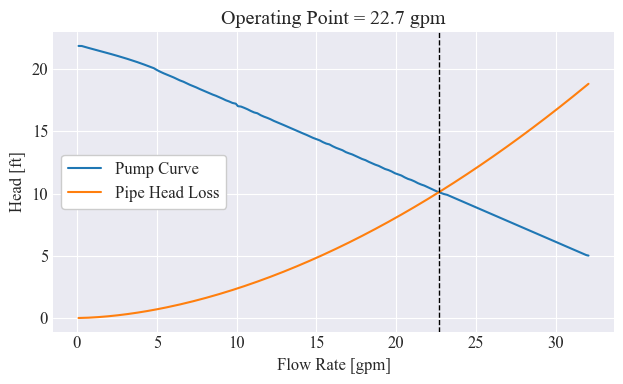

In [11]:
head_loss = [pipe.head_loss_feet(gpm) for gpm in pump.data.index]

fig, ax = plt.subplots(figsize=figsize)
ax.plot(pump.data, label='Pump Curve')
ax.plot(pump.data.index, head_loss, label='Pipe Head Loss')
#plot vertical line at operating point
ax.axvline(res.root, color='k', ls='--', lw=1)
ax.legend(frameon=True, facecolor='white', framealpha=1, loc=6)
ax.set_xlabel("Flow Rate [gpm]")
ax.set_ylabel("Head [ft]")
ax.set_title(f'Operating Point = {res.root:.1f} gpm')
fig.tight_layout()
fig.savefig(plots_folder/'intersection_solution.png')

## Perform Design Space Exploration

Sweep pipe length from 100 to 1000 feet and compute the systems flow rate

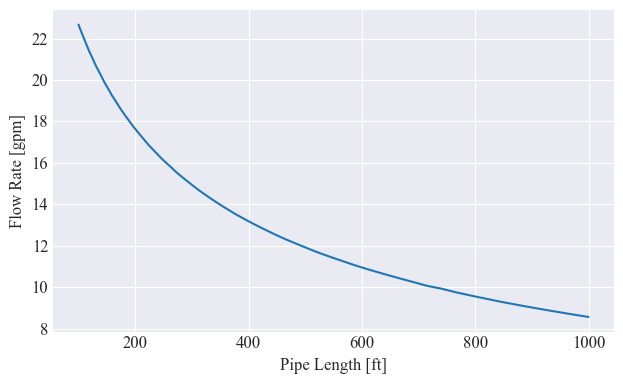

In [12]:
#sweep pipe length from 100 to 1000 feet
lengths_feet = np.linspace(100, 1000, 1000)
lengths_meters = lengths_feet*FEET_TO_METERS

flow_rates = []
for l in lengths_meters:
    #update pipe length
    sys.pipe.L = l 
    #compute new flow rate solution
    res = sys.get_operating_point()
    #append solution to flow rates list
    flow_rates.append(res.root) 
    
#plot results
fig, ax = plt.subplots(figsize=figsize)
ax.plot(lengths_feet, flow_rates)
ax.set_xlabel("Pipe Length [ft]")
ax.set_ylabel("Flow Rate [gpm]")
# ax.set_ylim(bottom=0)
fig.tight_layout()
fig.savefig(plots_folder/'flow_vs_pipe_length.png')